In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Read Data**

In [2]:
url = 'https://raw.githubusercontent.com/cs575ts/Assignments/main/Assignment_2/D1.csv'

dataframe = pd.read_csv(url)

In [3]:
dataframe.head()

,Time,Ads
0,13-09-2017 00:00,80115
1,13-09-2017 01:00,79885
2,13-09-2017 02:00,89325
3,13-09-2017 03:00,101930
4,13-09-2017 04:00,121630


**Triple Exponential Smoothing without inbuilt function**

In [4]:
alpha_array = [0.5,0.7,0.95]
gamma_array = [0.06,0.03,0.01]
beta_array = [0.4,0.65,0.98]

#Initial components
 #level
s1 = dataframe['Ads'][0] 

 #Trend
season_len = 24            
sum = 0.0
for i in range(season_len):
  sum += float(dataframe['Ads'][i+season_len] - dataframe['Ads'][i]) / season_len
  b1 = sum / season_len


 #Seasonal
seasonals = {}
season_averages = []
n_seasons = int(len(dataframe['Ads'])/season_len)
# compute season averages
for j in range(n_seasons):
  season_averages.append(np.sum(dataframe['Ads'][season_len*j:season_len*j+season_len])/float(season_len))
# compute initial values
for i in range(season_len):
  sum_of_vals_over_avg = 0.0
  for j in range(n_seasons):
    sum_of_vals_over_avg += dataframe['Ads'][season_len*j+i]-season_averages[j]
    seasonals[i] = sum_of_vals_over_avg/n_seasons

**Function for single exponential smoothing**

In [5]:
def dataset_with_interval(dataset):
  
  forecasted_list=[]
  mse_list = []
  complete_fc_val_list=[]
  for alpha in alpha_array:
    for gamma in gamma_array:
      for beta in beta_array:
        s = [s1]
        b = [b1]
        f = []
        for i in range(len(dataset)):
          if (i<(len(dataset)-1)):
            st = alpha*(dataset[i+1]-seasonals[i%season_len]) + ((1-alpha)*(s[i]+b[i]))
            s.append(st)       
            bt = gamma*(s[i+1]-s[i]) + (1-gamma)*b[i] 
            b.append(bt)   
            seasonals[i%season_len] = beta*(dataset[i+1]-s[i+1]) + (1-beta)*seasonals[i%season_len]
            ft = st+bt+seasonals[i%season_len]
            f.append(ft)

        f.insert(0,s1)
        fc_s = f.copy()
        forecasted_list.append(f[-1])
        complete_fc_val_list.append(fc_s)

        cp_df = dataset.copy()
        cp_df = np.c_[ cp_df, f ] 
        error_array = cp_df[:,0] - cp_df[:,1]
        cp_df = np.c_[ cp_df, error_array ]
        sqer_arr = (cp_df[:,2])**2
        cp_df = np.c_[cp_df,sqer_arr]

        MSE = np.sum(cp_df[1:len(dataset),3])/(len(cp_df)-1) 
        mse_list.append(MSE)

  return mse_list,forecasted_list,complete_fc_val_list

**Different interval data array**

In [6]:
data= dataframe.values
dataset_array = [data[0::1][:,1],data[0::2][:,1],data[0::4][:,1],data[0::8][:,1],data[0::12][:,1],data[0::24][:,1],data[0::48][:,1]]


**Different interval time array**

In [7]:
time_array = []
for d in dataset_array:
  t = range(d.shape[0])
  time_array.append(t)

**Function call for MSE and prediction calculations**

In [8]:
final_mse_list = []
final_forecasted_list = []
final_fc_val_list = []
for df in dataset_array:
  mse_list,forecasted_list,complete_fc_val_list = dataset_with_interval(df)
  final_mse_list.append(mse_list)
  final_fc_val_list.append(complete_fc_val_list)
  final_forecasted_list.append(forecasted_list)

In [9]:
min_idx=[]
for minval in final_mse_list: 
  minidx = minval.index(min(minval))
  min_idx.append(minidx)

In [10]:
interval_arr = [1,2,4,8,12,24,48]

**Plotting function for predicted values ad actual values**

In [11]:
def plotting_function(fc_val,data_val,time_val,interval_val):
  fig = plt.gcf()
  plt.plot(time_val,data_val,color='g',label='Original')
  plt.plot(time_val,fc_val,color='r',label='Forcasted')
  fig.set_size_inches(12,8)
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Ads')
  plt.title('Prediction at '+str(interval_val)+' hour interval at the least MSE')
  plt.figure()
  plt.close

**Plotting of predicted values and actual values for different intervals**

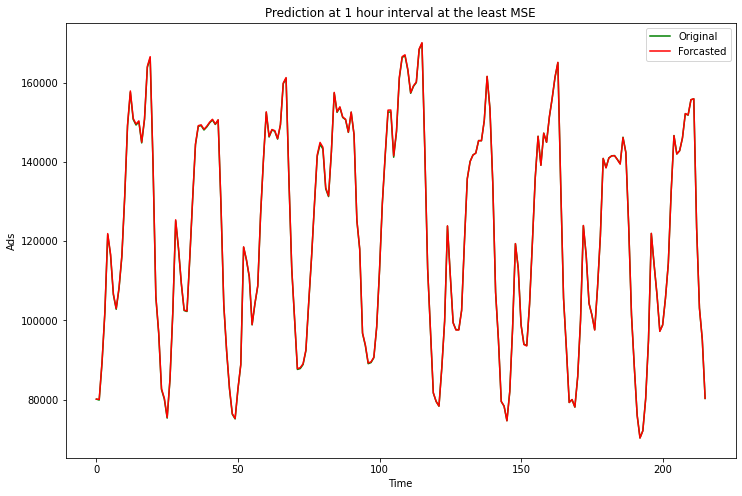

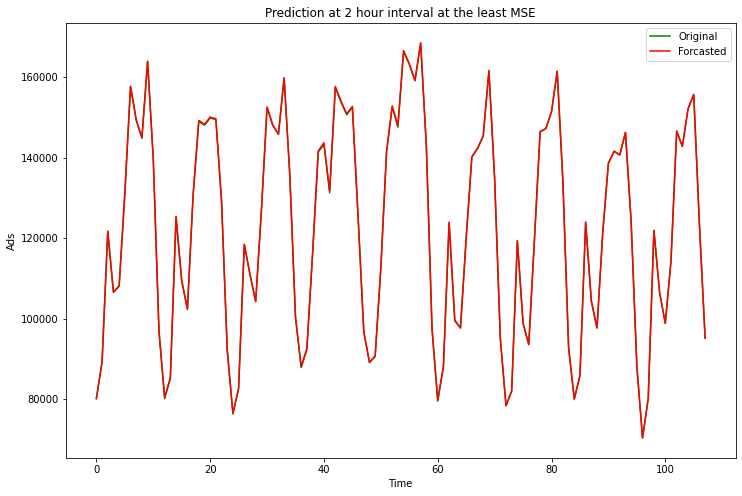

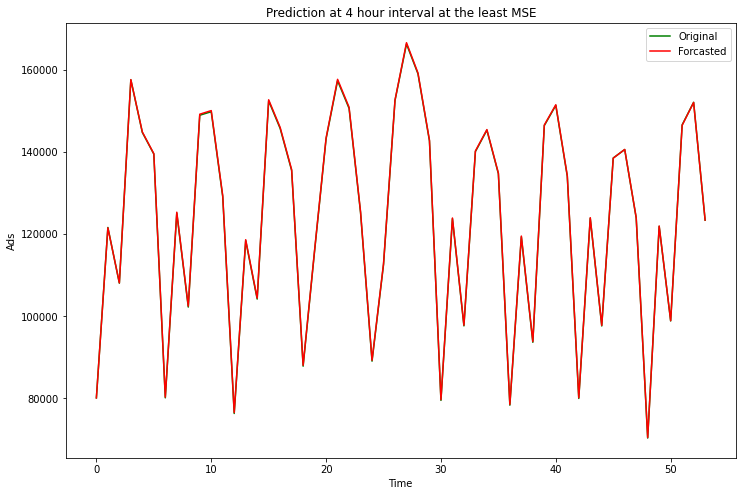

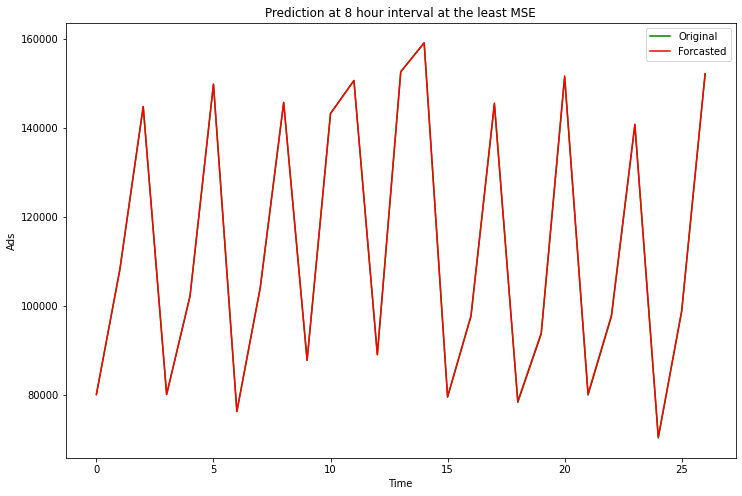

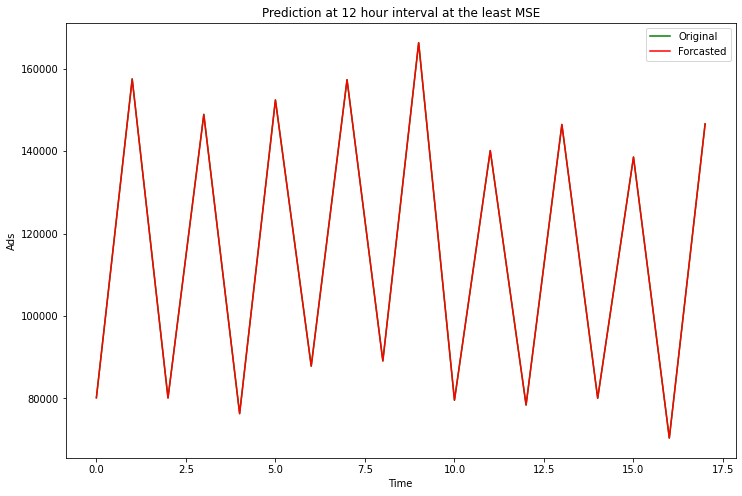

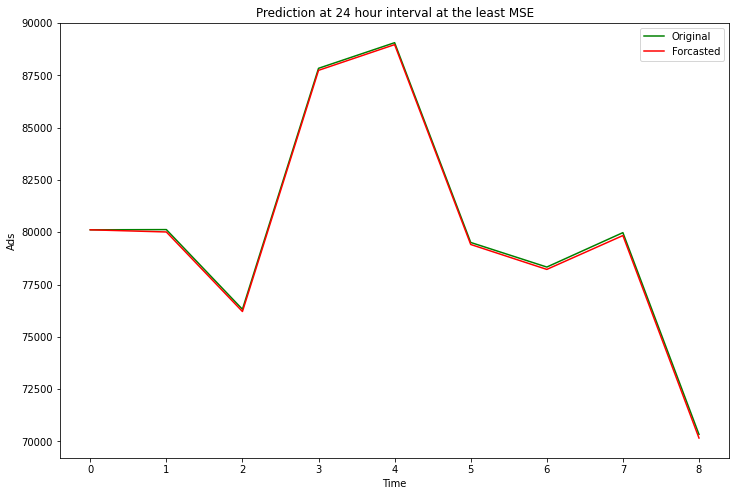

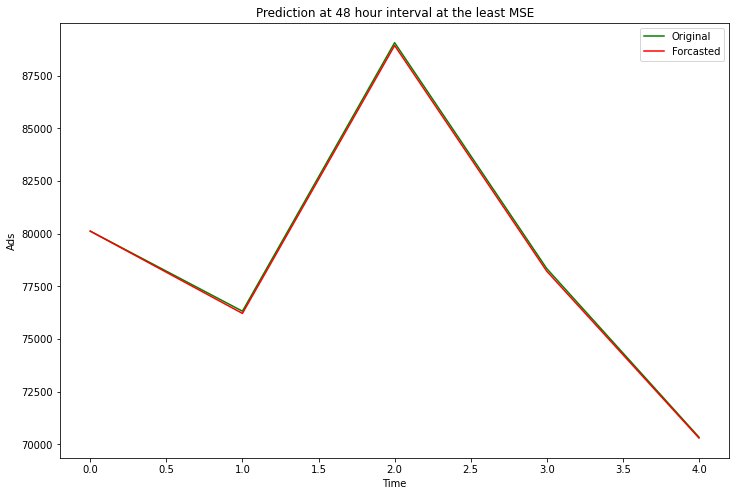

<Figure size 432x288 with 0 Axes>

In [12]:
for fc_idx in range(7):
  plotting_function(final_fc_val_list[fc_idx][min_idx[fc_idx]],dataset_array[fc_idx],time_array[fc_idx],interval_arr[fc_idx])  

**Table of Least MSE value for each interval**

In [13]:
from tabulate import tabulate

tab_array = []
for n in range(7):
  tab = [(interval_arr[n]),final_mse_list[n][min_idx[n]]]
  tab_array.append(tab)

table = tabulate(tab_array, headers=['interval(in hours)', 'Least MSE'], tablefmt='orgtbl')

print(table)

|   interval(in hours) |   Least MSE |
|----------------------+-------------|
|                    1 |    24640.1  |
|                    2 |    30734.3  |
|                    4 |    34215.3  |
|                    8 |    23819.9  |
|                   12 |     3748.02 |
|                   24 |    14193.8  |
|                   48 |    11473.7  |


**Plotting of MSE at different intervals**

In [14]:

def mse_plotting_func(inter_val,mseval):
  fig = plt.gcf()
  ax = fig.add_axes([0,0,1,1])
  rects = ax.bar(inter_val,round(mseval,2),color='b')
  for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom') 
  fig.set_size_inches(12,8)
  plt.xlabel('Interval(in hours)')
  plt.ylabel('MSE')
  plt.title('MSE VS Interval')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


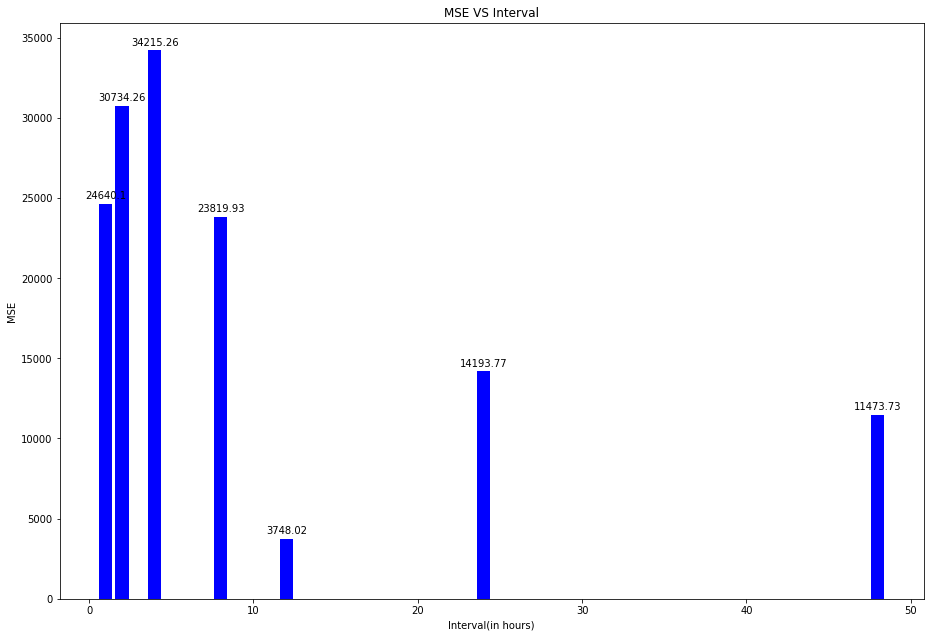

In [15]:
for idx in range(7):
  mse_plotting_func(interval_arr[idx],final_mse_list[idx][min_idx[idx]])

**Comparing forecasted values with inbuilt function**

In [16]:
#using inbuilt function
model = ExponentialSmoothing(dataframe['Ads'])
fit1 = model.fit(smoothing_level=0.95, smoothing_slope=.01, smoothing_seasonal=0.98).forecast()
print('forcasted value using inbuilt function for alpha=0.95, gamma=0.01, beta=0.98 : ',float(fit1))


forcasted value using inbuilt function for alpha=0.95, gamma=0.01, beta=0.98 :  81051.05483790384


In [17]:
print('forcasted value for using own function alpha=0.95, gamma=0.01, beta=0.98 : ',final_forecasted_list[0][min_idx[0]])      #our value

forcasted value for using own function alpha=0.95, gamma=0.01, beta=0.98 :  80326.1450076634


In [19]:
from sklearn.metrics import mean_squared_error

dataframe['pred_val'] = model.fit(smoothing_level=0.9,optimized=False).fittedvalues.shift(0)

MSE = mean_squared_error(dataframe.pred_val.dropna(),dataframe.Ads)

In [20]:
print('MSE (inbuilt function): ',MSE)
print('MSE (own function): ',final_mse_list[0][min_idx[0]])

MSE (inbuilt function):  158300390.4671972
MSE (own function):  24640.097401183593


In [21]:
print('Difference in error: ',abs(final_mse_list[0][min_idx[0]]-MSE))

Difference in error:  158275750.36979604
